# Installation des dépendances

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from scipy.io.wavfile import read,write
import sounddevice as sd
from scipy.signal import periodogram

# PHASE D'EMISSION

In [2]:
#Message à envoyer à l'agence.
#Ici, la fonction input() renvoie une valeur dont le type correspond à ce que l'utilisateur a entré. 

message_envoie = str(input("Veuillez entrer votre message (5 à 10 caractères) : "))
#Vérification des conditions (tant que notre message n'est pas entre 5 et 10 caractères, nous restons dans la boucle).
while not 5 <= len(message_envoie) <= 10:
    clear_output()
    message_envoie = str(input("Veuillez entrer votre message (5 à 10 caractères) : "))

Veuillez entrer votre message (5 à 10 caractères) : salut


## CONVERSION DU MESSAGE EN ASCII PUIS EN BINAIRE

In [3]:
text_to_binary = "" #Variable dans laquelle sera notre texte converti en binaire.
for x in message_envoie:
    text_to_binary += bin(ord(x))[2:].zfill(8) #Ici, nous convertissons chaque caractères de notre mesage en binaire et les concaténons.

message = []
message[:] = text_to_binary #Ajoute chaque caractère du tableau un à un dans un tableau message.

message_int = text_to_binary
message_int = [0 if i=="0"else 1 for i in message] #Ici, nos éléments du tableau "message" était sous la forme de str, nous remplaçons donc ces valeurs par des entiers dans le tableau "message_int".
print(f"Conversion du message en binaire: {message_int}")

Conversion du message en binaire: [0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0]


## BIT DE PARITE

In [4]:
#On initialise nos variables c et i étant égale à 0
#La variable c correspond à notre bit de parité (au niveau de l'émission)

c=0
i=0
bit_parite = 0
#Calcul du nombre de 1 dans notre message binaire, si le nombre est impair, notre bit de parité est
#à 1. Sinon 0.
for i in message_int:
    if i==1:
        c += 1
        if c%2 == 0:
            bit_parite = 1
        else:
            bit_parite = 0
    
print(f"Il y a {c} « 1 » dans notre message binaire.")  
print(f"Le bit de parité est donc à {bit_parite}.")

Il y a 21 « 1 » dans notre message binaire.
Le bit de parité est donc à 0.


## CREATION DE LA TRAME

In [5]:
#On redéfinit c pour qu'il soit considéré comme un tableau pour pouvoir l'additionner avec d'autre tableau
bit_parite = [bit_parite]

#On définit la valeur de notre fanion de départ et de celui de fin
fanion1 = [0,1,1,1,1,1,1,0]
fanion2 = [0,1,1,1,1,1,1,0]

#On ajoute nos fanions ainsi que notre bit de parité au message binaire afin de former une trame
trame = fanion1 + message_int + bit_parite + fanion2

#On affiche notre trame
print(f"L'allure de la trame est la suivante : \n{trame}")

L'allure de la trame est la suivante : 
[0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0]


## CONTROLE DE REDONDANCE CYCLIQUE (EMETEUR)

In [6]:
trame_str = ""
for elem in trame:  
    trame_str += str(elem)

# Fonction XOR  utilisée par division 
def xor(a, b):
    # initialiser le résultat
    result = [] 
    # si les bits sont idem, alors XOR vaut 0, sinon 1
    for i in range(1, len(b)): 
        if a[i] == b[i]: 
            result.append('0') 
        else: 
            result.append('1') 
   
    return ''.join(result) 
   
# Division euclidienne
def div_eucli(divise, diviseur): 
   
    pick = len(diviseur) 
    tmp = divise[0 : pick] 
   
    while pick < len(divise): 
   
        if tmp[0] == '1': 

            tmp = xor(diviseur, tmp) + divise[pick] 
   
        else:    
            tmp = xor('0'*pick, tmp) + divise[pick] 
    
        pick += 1
    
    if tmp[0] == '1': 
        tmp = xor(diviseur, tmp) 
    else: 
        tmp = xor('0'*pick, tmp) 
   
    checkword = tmp 
    return checkword 
    

# Fonction d'encodage 
# On lui donne les données (augmentée de N-bits 0 qui est la taille de la clé) et la clé (Key) qui (polynome générateur)
def encodeData(data, key): 
    l_key = len(key) 

    appended_data = data + '0'*(l_key-1) 
    remainder = div_eucli(appended_data, key) 
   

    codeword = data + remainder 
    return codeword

key= '10011'
print(f"les données à envoyer sont : {trame_str}")
print (f"La clé CRC est : {key}")


data_crc = encodeData(trame_str, key)
# print("Encoded data for transmission: ", Encoded_data)
data_crc= [0 if i=="0"else 1 for i in data_crc]

print ("les données encodées avec la clé key sont : {data_crc}")

les données à envoyer sont : 011111100111001101100001011011000111010101110100001111110
La clé CRC est : 10011
les données encodées avec la clé key sont : {data_crc}


## ENCODAGE MANCHESTER
Pour coder le signal en Manchester (ici c'est une matrice binaire, provenant d'une conversion d'un texte en binaire), il faut faire une boucle avec un pas de 1. On commence par 0 et on fait 1 boucle pour chaque bit du message. Dans cette boucle on met une fonction if qui dit vérifie le bit de la matrice: si le bit est 0, alors on met un 0 puis un 1 dans notre nouvelle matrice, sinon (si le bit est 1) on met un 1 puis un 0.

On aura au final une matrice deux fois plus grande avec à chaque fois le bit de l'information et un bit de codage qui rend le tout illisible. On a donc codé notre information.

In [7]:
codeManchester = [] # Initialisation de la matrice

for i in range (0,len(data_crc)):  # Boucle qui va de 0 au nombre total de bits du message
    if data_crc[i]==0:             # Si le bit est 0
 
        codeManchester.append(0)  # Bit de l'information
        codeManchester.append(1)  # Bit de codage (sans réel sens)
 
    else:                         # Si le bit est 1
 
        codeManchester.append(1)  # Bit de l'information
        codeManchester.append(0)  # Bit de codage (sans réel sens)
        
print (f"\nLes données codées en Manchester donnent : {codeManchester}")


Les données codées en Manchester donnent : [0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]


## MODULATION ASK

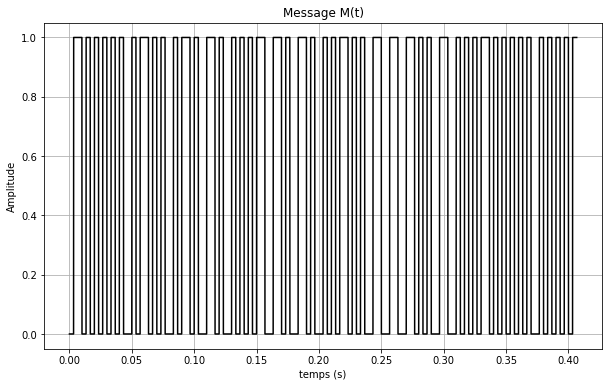

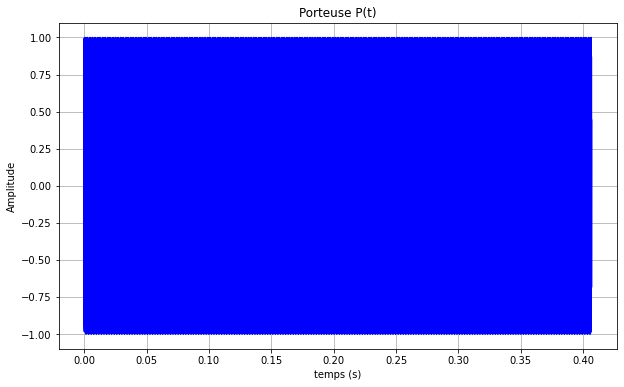

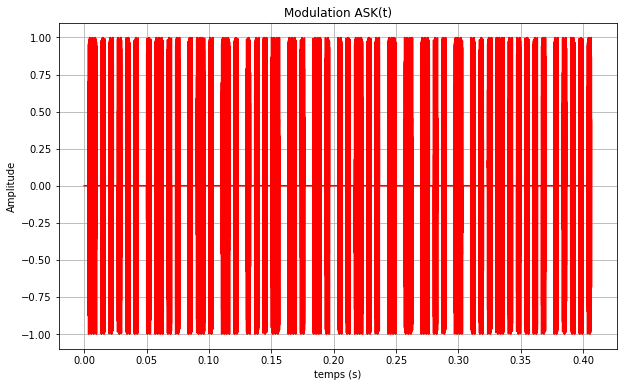

In [8]:
M =  codeManchester # Message binaire M
Fe =  44100 # Fréquence d'échantillonnage
                         
baud = 300 # Débit souhaité sur le canal de transmission exprimé en bit/s
Nbits =  len(M) # Nombre de bits initial (taille du message M)
Ns = int(Fe/baud) # Nombre de symboles par bit (Fréq d'echan / Débit binaire) 
N = int(Ns*Nbits) # Nombre de bits total à moduler (Nombre de symboles par bit * Nombre de bits

# On génère le message binaire dupliqué
M_duplique= np.repeat(M,Ns) # On peut aussi le faire avec la fonction tile de numpy
                                     
# On génère le vecteur temps
t = np.linspace(0,N/Fe,N)                        

# On génère la porteuse P(t)
Ap = 1                     
Fp =20000 # Fréquence de l'onde porteuse 
Porteuse = Ap*np.sin(2*np.pi*Fp*t)             

# On réalise la modualtion en amplitude  
ASK =  M_duplique*Porteuse                
                         
#Affichage du message M
plt.figure (figsize = (10,6))
plt.plot(t,M_duplique,'black')
plt.title('Message M(t)')
plt.xlabel('temps (s)')
plt.ylabel('Amplitude')
plt.grid()

#Affichage de la porteuse 
plt.figure (figsize = (10,6))
plt.plot(t,Porteuse,'b')
plt.title('Porteuse P(t)')
plt.xlabel('temps (s)')
plt.ylabel('Amplitude')
plt.grid()

#Affichage du résultat de la modualtion ASK
plt.figure (figsize = (10,6))
plt.plot(t,ASK,'r')
plt.title('Modulation ASK(t)')
plt.xlabel('temps (s)')
plt.ylabel('Amplitude')
plt.grid()


## CONVERSION NUMERIQUE/ANALOGIQUE

In [9]:
write("message_son.wav",Fe,ASK)

_,analogue_message = read('message_son.wav')

sd.play(analogue_message, Fe)# L'instruction sd.play permet de jouer le son d'un fichier
status = sd.wait() # Attendre la fin du son

# PHASE DE RECEPTION

## CONVERSION ANALOGIQUE/NUMERIQUE

In [10]:
f,ecoute_message = read('message_son.wav')
print(ecoute_message)

[ 0.          0.         -0.         ...  0.44696021 -0.68549324
  0.8660254 ]


## FILTRAGE DU SIGNAL RECU PAR UN FILTRE PASSE-BANDE

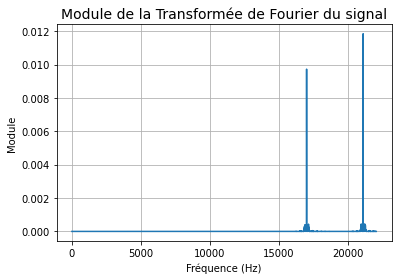

In [11]:
f2 = 3000                             # fréquence du signal S2

S2 = np.sin(2*np.pi*f2*t)            # création d'une sinusoïde de fréquence f2
Multi = ecoute_message*S2

Fe2 =  44100
f,FFT = periodogram(Multi,Fe2)


# Affichage du de la transformée de Fourier FFT du signal du type S=S1*S2-----------------
plt.plot(f,FFT) # affichage via la fonction plot de Matplotlib
plt.xlabel('Fréquence (Hz)') # définition de l'axe des abscisses
plt.ylabel('Module') # définition de l'axe des ordonnées
plt.grid()
plt.title ('Module de la Transformée de Fourier du signal',fontsize=14)
plt.show() # affichage des courbes

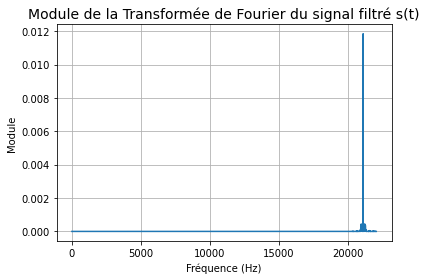

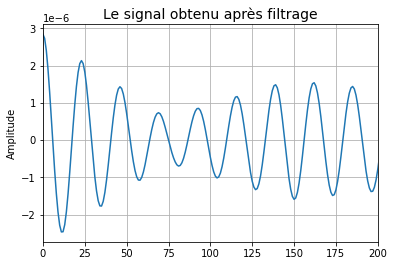

In [12]:
fc = 19000
FFT_filtre = FFT

for i in range(len(f)):
    if f[i] < fc: # on coupe toutes les fréquences < 19 000 Hz 
        FFT_filtre[i] = 0.0

# on calcule la transfomrée de Fourier inverse du signal après filtrage en utilsant la fonction ifft de Python
# la FFT inverse permet de revenir dans l'espace temporal (espace fréquentiel -> espace temps)
FFT_inverse = np.fft.ifft(FFT_filtre)
T = np.real(FFT_inverse) #Passage de la partie imaginaire vers la partie réelle

plt.plot(f,FFT_filtre) # affichage via la fonction plot de Matplotlib
plt.xlabel('Fréquence (Hz)') # définition de l'axe des abscisses
plt.ylabel('Module') # définition de l'axe des ordonnées
plt.grid()
plt.title ('Module de la Transformée de Fourier du signal filtré s(t)',fontsize=14)
plt.show()

plt.plot(np.real(FFT_inverse)) # affichage via la fonction plot de Matplotlib de la partie réelle
plt.ylabel('Amplitude') # définition de l'axe des ordonnées
plt.xlim(0, 200)
plt.grid()
plt.title ('Le signal obtenu après filtrage',fontsize=14)
plt.show()

# DEMODULATION ASK

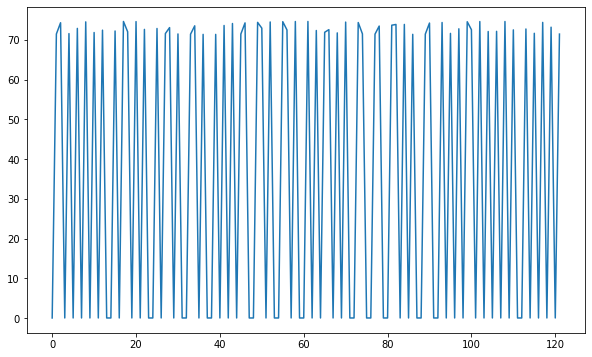

In [13]:

S = Porteuse #générer la porteuse déja utilisée plus haut lors de la modulation (nommée Porteuse)

Produit = ecoute_message*S# multiplier le signal modulé par la signal de la porteuse S1 (bit 1)

# Intégration des 2 résultats bit1 et bit0 sur période de T = [0, Ns], Ns : taille du symbole envoyé 
# par la méthode des trapèzes (fonction numpy.trapz en Python) (l'approche la plus simple)  

recu = [] # Résulat de l'intégration                         

i = 0
for i in range(0,N,Ns):
    recu.append(np.trapz(Produit[i:i+Ns]))

# Remarque sur la fonction trapz :

  # on se contente d’intégrer sur un seul axe et c'est suffisant ici
  # si les données ne sont pas réparties uniformément par l'échantillonnage, il faut aussi intégrer sur l'axe des abscisses comme suit :
  # np.trapz(Produit[i:i+Ns],t[i:i+Ns]))

plt.figure(figsize = (10,6))
plt.plot(recu)
plt.show()

In [14]:
message_demodule_ASK = []

#Permet de transformer nos valeurs numériques en suite de 0 et de 1.
#Si la valeur est supérieure strictement à 0, on ajoute 1 à notre liste. Sinon 0.
for ii in range (0,len(recu)):
    if recu[ii] > 0:
        message_demodule_ASK.extend([int(1)]) 
    if recu[ii] <= 0:
        message_demodule_ASK.extend([int(0)])
print(message_demodule_ASK)

assert message_demodule_ASK == codeManchester

[0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]


# DECODAGE MANCHESTER
Une fois l'information codée reçue, on doit la décoder. Comme c'est un codage Manchester, on doit retirer de la matrice les bits de codage. Comme on sait qu'on a mis d'abord le bit de l'information puis le bit de codage on doit faire une boucle qui a un pas de 2, le bit indiqué par cette boucle sera à chaque fois intégré dans une variable tableau, ce qui éliminera 1 bit sur 2, les bits de codage.

In [15]:
# message_decode = "".join(["0" if i==0 else "1" for i in message_demodule_ASK])
# print(message_decode)
            
message_decode = [int(message_demodule_ASK[i]) for i in range(0, len(message_demodule_ASK),2)]
print("La trame décodée par le codage manchester est la suivante:",message_decode)

La trame décodée par le codage manchester est la suivante: [0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]


# RECUPERATION DE LA TRAME

In [16]:
#On supprime nos fanions afin de garder seulement notre message encode avec le controle de redondance cyclique
del message_decode[(len(message_decode)-12):(len(message_decode))]
del message_decode[0:8]

In [17]:
#On affiche la trame sans les fanions de début et de fin

message_crc= "".join(["0" if i==0 else "1" for i in message_decode])
print("Voici la trame sans les fanions de début et de fin",message_crc)

Voici la trame sans les fanions de début et de fin 01110011011000010110110001110101011101000


In [18]:
#On calcul le bit de parité lors de la récéption du signal
c1=0
i=0

c0=message_decode[len(message_decode)-1]

#On supprime le dernier bit de la trame (elle correspond au bit de parité)
del message_decode[-1]

#On calcul le bit de parité
for i in range(len(message_decode)):
    if message_decode[i]==1:
        c1=c1+1 
    else:
        c1=c1
if c1 == c:
    print("Il n'y a pas d'erreur")
else :
    print("pas d'erreur")
#Affiche l'information du message texte en binaire
print(message_decode)

Il n'y a pas d'erreur
[0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0]


# CONTROLE DE REDONDANCE CYCLIQUE (RECEPTEUR)

In [19]:
key='10011'   # On utilise la même clé à l'émission (polynome générateur)

#print(key)

# Fonction XOR  utilisée par division 
def xor(a, b): 
   
    # initialiser le résultat
    result = [] 
   

    # si les bits sont idem, alors XOR vaut 0, sinon 1
    for i in range(1, len(b)): 
        if a[i] == b[i]: 
            result.append('0') 
        else: 
            result.append('1') 
   
    return ''.join(result) 
   
# Division euclidienne
def mod2div(divident, divisor): 
   
    pick = len(divisor) 
    tmp = divident[0 : pick] 
   
    while pick < len(divident): 
   
        if tmp[0] == '1': 

            tmp = xor(divisor, tmp) + divident[pick] 
   
        else:    
            tmp = xor('0'*pick, tmp) + divident[pick] 
    
        pick += 1
    
    if tmp[0] == '1': 
        tmp = xor(divisor, tmp) 
    else: 
        tmp = xor('0'*pick, tmp) 
   
    checkword = tmp 
    return checkword 

 
# On donne la focntion décodeData les données encodées en CRC et la clé utilisée
def decodeData(data_crc, key): 
   
    l_key = len(key) 
    appended_data = data_crc + '0'*(l_key-1) 
    remainder = mod2div(appended_data, key) 
   
    return remainder 



key= '10011'   # On utilise la même clé à l'émission (polynome générateur)
check = decodeData(message_crc, key) 



print("Le reste de la division après décodage est ->"+check) 
temp = "0" * (len(key) - 1) 


if check == temp: 
    print("Bravo! les données -> "+message_crc+ " <- sont bien reçues!") 
else: 
    print ("Erreur de réception !") 


Le reste de la division après décodage est ->1011
Erreur de réception !


# SUPPRESION DU CONTROLE DE REDONDANCE CYCLIQUE

In [20]:
data_crc_decode2= [0 if i=="0" else 1 for i in message_crc]
del data_crc_decode2[(len(data_crc_decode2)-4):(len(data_crc_decode2))]
print("Voici le message sans le controle de redondance cyclique",data_crc_decode2)

Voici le message sans le controle de redondance cyclique [0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0]


# CONVERSION DU MESSAGE BINAIRE EN CHAINE DE CARACTERE

In [21]:
bin_data = ""
for elem in data_crc_decode2:  
    bin_data += str(elem)
    
data_reçu =' '

# Fonction BinarytoDecimal() function (conversion bianire ==> décimal)
def BinaryToDecimal(binary):  
    binary1 = binary 
    decimal, i, n = 0, 0, 0 #initialisation des variables
    
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return (decimal)


# Découper les données binaire d'entrée et la convertir en décimal puis la convertir en chaîne par bloc de 8 
for i in range(0, len(bin_data), 8): 
    # découper le bin_data de la plage d'index [0, 7] (car une caractère ASCII est codé sur 7 bits) ett le stocker sous forme d'entier dans temp_data
    temp_data = int(bin_data[i+1:i+8])
      
       
    # Passer (temp_data) dans la fonction BinarytoDecimal ()
    # pour obtenir la valeur décimale correspondante de (temp_data)
    decimal_data = BinaryToDecimal(temp_data)

    # Décodage de la valeur décimale renvoyée par
    # la Fonction BinarytoDecimal (), en utilisant chr ()
    # fonction qui renvoie la chaîne correspondante
    # caractère pour une valeur ASCII donnée et enregistrez-le
    # dans data_recu
    data_reçu = data_reçu + chr(decimal_data) 

# Affichage du result 
print("Le message reçu est :", 
      data_reçu) 

Le message reçu est :  salu
